In [1]:
from linkage.linkage import *
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
%matplotlib ipympl

#### Construct dataset display it

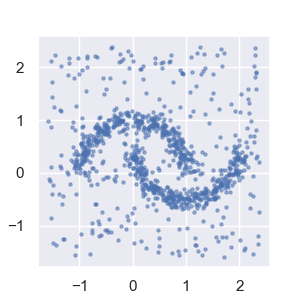

In [2]:
from sklearn import datasets

N_DATAPOINTS = 1000

n_true_points = int(N_DATAPOINTS * 0.7) ; X, _ = datasets.make_moons(n_samples=n_true_points, noise=0.1, random_state=0)
np.random.seed(0) ; n_noise = N_DATAPOINTS - n_true_points ; noise = (np.random.random_sample((n_noise,2)) - 0.4) * 4 ; X = np.vstack((X,noise))
fig1, ax1 = plt.subplots() ; fig1.set_figheight(3) ; fig1.set_figwidth(3)
_ = plt.scatter(X.T[0], X.T[1], s=5, alpha = 0.5)

We run the algorithm with several choices of curve to see the evolution of the cluster structure as we vary the parameter. We see that there are two high persistence vines well separated from the rest.

In [3]:
x = MPSpace(X)
x.fit()

x0 = x.connection_radius()

initial_k = 0.01 ; final_k = 0.4 ; N_PARAMETERS = 50
gammas = [ Gamma_curve.linear_interpolator_alpha_s_indexed(k, x0) for k in np.linspace(initial_k, final_k, num=N_PARAMETERS) ]
pds = x.gamma_prominence_vineyard(gammas)

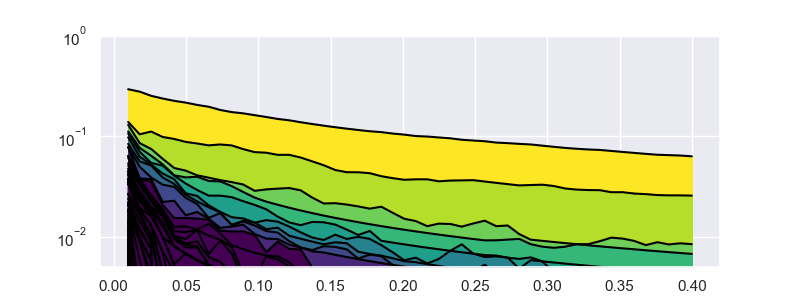

In [4]:
fig, ax = plt.subplots(figsize=(8,3))
plt.yscale("log")
plt.ylim([0.005,1])
pv = ProminenceVineyard(np.linspace(initial_k, final_k, num=N_PARAMETERS),pds)
pv.plot_prominence_vineyard(ax)

In [5]:
# we choose parameters using the prominence vineyard, and compute the flat clustering
kappa = 0.21
num_clusters = 2

gamma = Gamma_curve.linear_interpolator_alpha_s_indexed(kappa, x0)
hc = x.gamma_linkage(gamma)
c = hc.persistence_based_flattening(num_clusters=num_clusters)

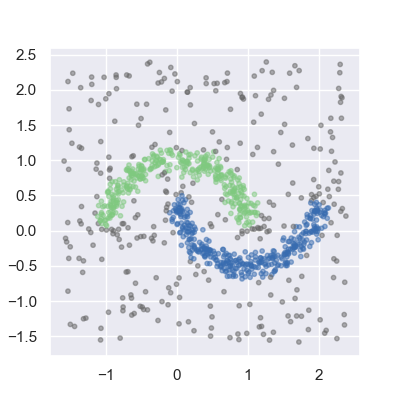

In [6]:
fig1, ax1 = plt.subplots() ; fig1.set_figheight(4) ; fig1.set_figwidth(4)
_ = plt.scatter(X.T[0], X.T[1], s=10, alpha = 0.5, c = -c[1], cmap="Accent")